## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [1]:
!pip install pennylane qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# import os
#import pennylane as qml
import time
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.extensions import Initialize
from qiskit.algorithms import optimizers
#from pennylane.templates import RandomLayers
#from pennylane_ionq import ops

'''
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
'''

'\nimport qiskit\nfrom qiskit import transpile, assemble\nfrom qiskit.visualization import *\nfrom qiskit.circuit.random import random_circuit\n\nimport torch\nfrom torch.autograd import Function\nfrom torchvision import datasets, transforms\nimport torch.optim as optim\nimport torch.nn as nn\nimport torch.nn.functional as F\n'

### 1-2. Setting of the main hyper-parameters of the model

In [3]:
BATCH_SIZE = 100
n_qubits = 9
n_params = 90
iteration = 200
n_epochs = 50
n_layers = 1    # Number of random layers

SAVE_PATH = "aeqis/" # Data saving folder
seed = 2022
np.random.seed(seed)        # Seed for NumPy random number generator
qiskit.utils.algorithm_globals.random_seed = seed

isReal = False # 'True' for real device or 'False' for simulator

## 2. Construct Quantum Circuit

### 2-1. One Qubit Unitary Circuit 

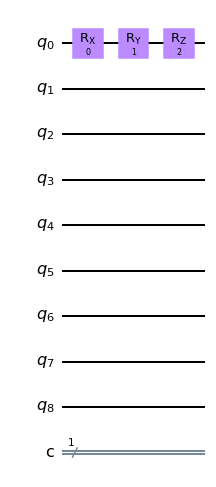

In [4]:
def one_qubit_unitary(params, wire):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '1 Qubit Unitary')

  circ.rx(params[0],wire)
  circ.ry(params[1],wire)
  circ.rz(params[2],wire)
  
  return circ

params = np.arange(0, 3)
one_qubit_unitary(params, 0).draw(output='mpl')

### 2-2. Two Qubits Unitary Circuit

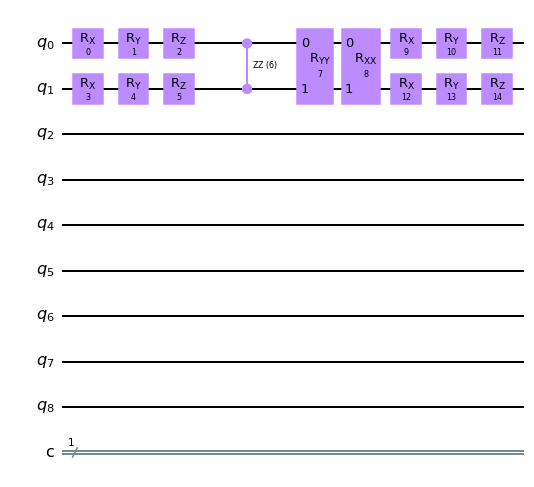

In [5]:
def two_qubit_unitary(params, wires):  # need 15 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '2 Qubit Unitary')
  circ.compose(one_qubit_unitary(params[0:3], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[3:6], wires[1]), inplace=True)
  circ.rzz(params[6], wires[0], wires[1])
  circ.ryy(params[7], wires[0], wires[1])
  circ.rxx(params[8], wires[0], wires[1])
  circ.compose(one_qubit_unitary(params[9:12], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[12:15], wires[1]), inplace=True)
  #circ.barrier()

  return circ

params = np.arange(0, 15)
two_qubit_unitary(params, [0,1]).draw(output='mpl')

### 2-3. Three Qubits Unitary Circuit

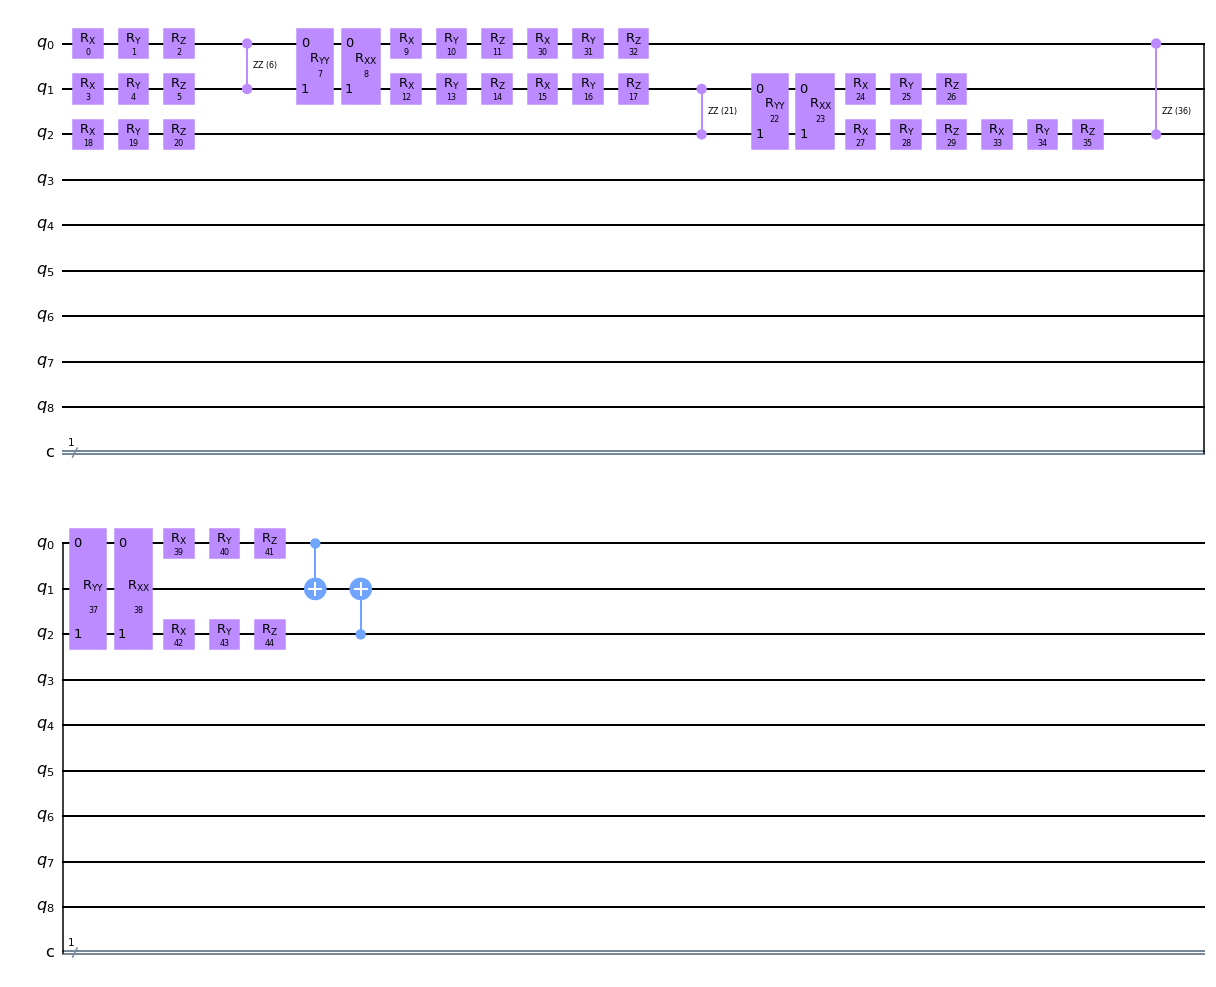

In [6]:
def three_qubit_unitary(params, wires):  # need 45 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '3 Qubit Unitary')
  circ.compose(two_qubit_unitary(params[0:15], [wires[0],wires[1]]), inplace=True)
  circ.compose(two_qubit_unitary(params[15:30], [wires[1],wires[2]]), inplace=True)
  circ.compose(two_qubit_unitary(params[30:45], [wires[0],wires[2]]), inplace=True)

  circ.cx(wires[0], wires[1])
  circ.cx(wires[2], wires[1])
  #circ.barrier()

  #circ.measure([wires[0],wires[2]], [0, 0])   
  #circ.barrier()

  return circ

params = np.arange(0, 45)
three_qubit_unitary(params, [0,1,2]).draw(output='mpl')

### 2-4. Decoder Circuit

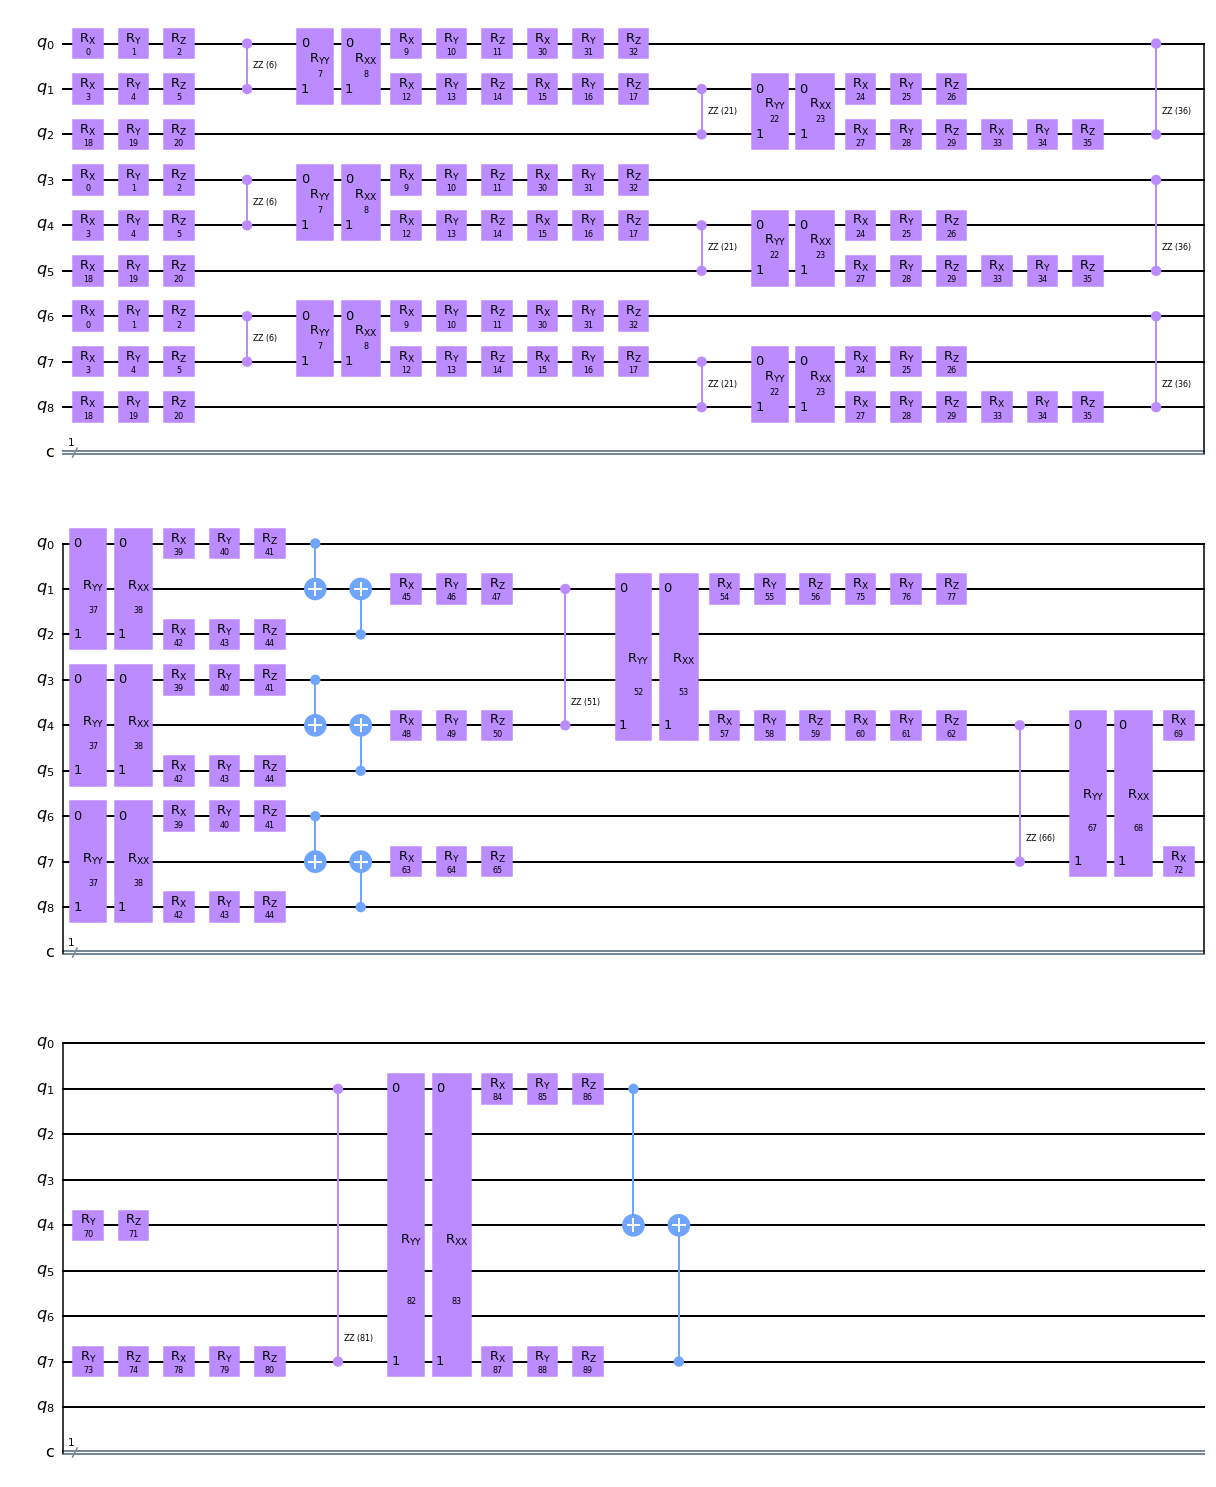

In [7]:
# Defining Decoder circuit.
def decoder(params, wires):  # need 90 parameters
  dec = QuantumCircuit(n_qubits, 1, name = 'Decoder')
  # U1
  dec.compose(three_qubit_unitary(params[0:45], wires[0:3]), inplace=True)
  dec.compose(three_qubit_unitary(params[0:45], wires[3:6]), inplace=True)
  dec.compose(three_qubit_unitary(params[0:45], wires[6:9]), inplace=True)

  # U2
  dec.compose(three_qubit_unitary(params[45:90], [1,4,7]), inplace=True)

  return dec

params = np.arange(0, 90)
decoder(params, np.arange(0,9)).draw(output='mpl')

### 2-5. Encoder Circuit

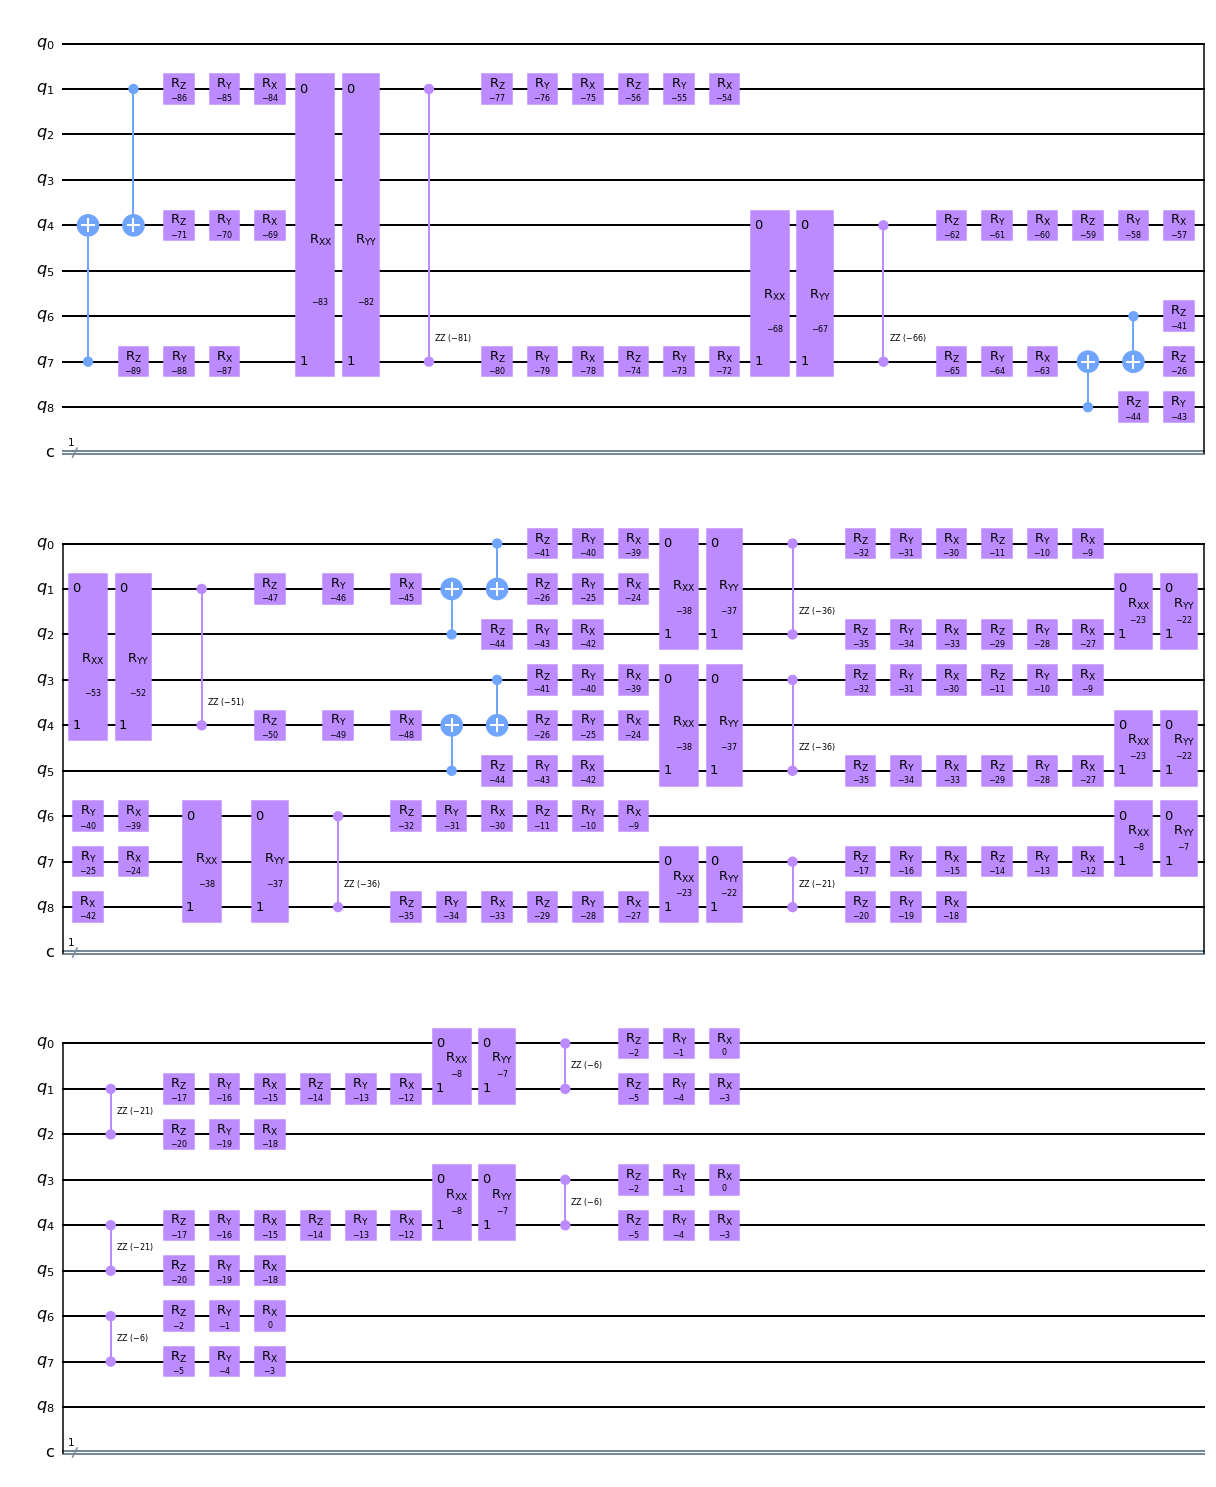

In [8]:
# Defining Encoder circuit. Encoder is inversion of Decoder.
def encoder(decoder):
    enc = QuantumCircuit(n_qubits, 1, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

# visualizing Encoder to check
params = np.arange(0, 90)
encoder(decoder(params, np.arange(0,9))).draw(output='mpl')

### 2-6. Complete Circuit

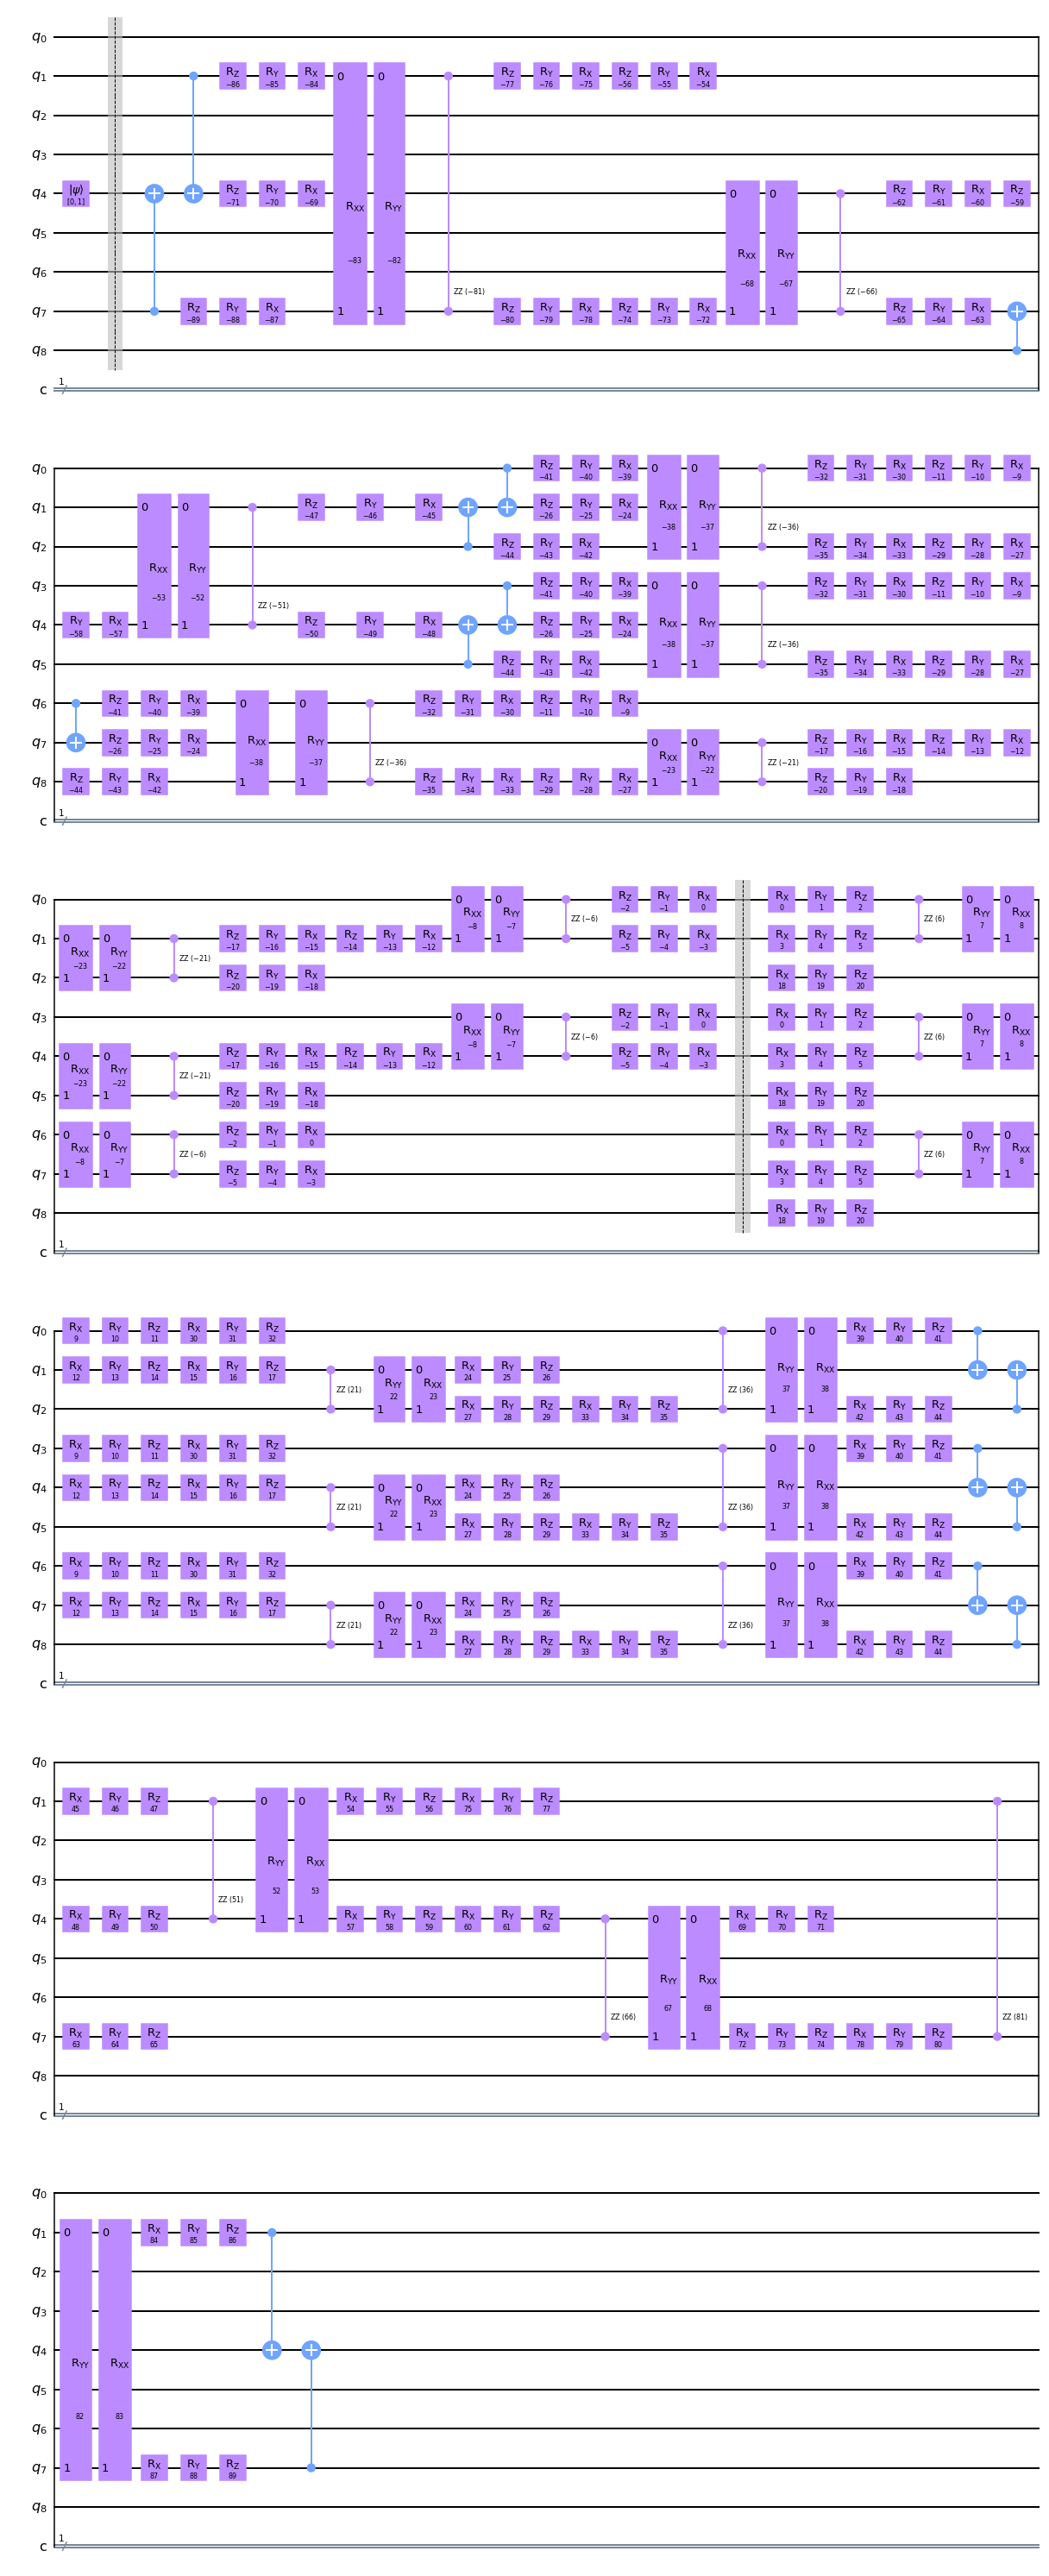

In [9]:
def qae(params, wires, input_state, error_qubit):  # need 90 parameters
  qc = QuantumCircuit(n_qubits, 1, name = 'Quantum Autoencoder')
  qc.append(input_state, [4])
  qc.barrier()

  dec = decoder(params, np.arange(0,9))
  qc.compose(encoder(dec), inplace=True)

  # Add noise
  # qc.barrier()
  # qc += noisemodel(error_qubit)
  
  qc.barrier()
  qc.compose(dec, inplace=True)

  #qc.barrier()
  #qc.measure(np.arange(0,9), np.arange(0,9)) 

  return qc

params = np.arange(0, 90)
wires = np.arange(0,9)
initial_state = [0, 1]
input_state = Initialize(initial_state)
qae(params, wires, input_state, 1).draw(output='mpl')

## 3. Optimization

### 3-1. Generalize Output State

In [10]:
def gen_states(output_state, target_state):
  alpha = 0
  for i in range(16):
    alpha += np.sum(np.power([abs(output_state[32*i+j]) for j in range(16)],2))
  alpha = np.sqrt(alpha)

  beta = 0
    
  if alpha == 0:
    for i in range(16):
      beta += np.power([abs(output_state[32*i+16+j]) for j in range(16)], 2)
    beta = np.sqrt(beta)

  else:
    pseudo_alpha = 0
    for i in range(16):
      beta += np.sum([output_state[32*i+16+j] for j in range(16)])
      pseudo_alpha += np.sum([output_state[32*i+j] for j in range(16)])
    beta = beta / pseudo_alpha * alpha
    
  a, b = target_state[0], target_state[1]
  if abs(a) == 0:
    b = abs(b)
  else:
    b = (b / a) * abs(a)
    a = abs(a)
    
  return np.array([alpha, beta]), np.array([a, b])

### 3-2. Configuring Qiskit Backend

In [11]:
if isReal:
  #from qiskit.providers.ibmq
  backend = qml.device("qiskit.ibmq", wires=n_qubits)
else:
  #from qiskit.providers.aer import AerSimulator
  #backend = AerSimulator(method='statevector')
  from qiskit import Aer
  backend = Aer.get_backend('statevector_simulator')

### 3-3. Create Cost Function

In [12]:
def cost(params, input_batch):
  cost = 0
    
  for input_state in input_batch:
    target_state = input_state
    # initialize state
    input_state = Initialize(input_state)
        
    for error_qubit in range(-1, 3):
      # Obtain a quantum circuit instance from the paramters
      qc = qae(params, np.arange(0,9), input_state, error_qubit)

      # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
      result = execute(qc, backend).result()
      output_state = result.get_statevector(qc)
      output_state = np.array(output_state)
      output_state, target_state = gen_states(output_state, target_state)
      # adding cost for single circuit
      cost += np.linalg.norm(output_state - target_state)
      
  # returning total cost
  return cost

### 3-4. Define Batch Generator & Optimizer

In [13]:
# Function to create batch according to batch size
def create_batch(batch_size):
  # Function to return an array after normalizing the elements
  def normalize(arr):
    return arr / np.linalg.norm(arr)
  # Generating random_states
  random_states = np.random.rand(batch_size * 2) + np.random.rand(batch_size * 2)*1j
  # Creating normalized input states from random states and appending to an array
  input_batch = np.array([normalize([random_states[i], random_states[i + 1]]) for i in range(0, 2 * batch_size, 2)])
  # Creating target states corresponding to the input states
  # target_states = [[input_states[i][0], 0, input_states[i][1], 0, 0, 0, 0, 0] for i in range (batch_size)]

  return input_batch

In [14]:
def optimize_circuit(initial_params, iteration, num_epoch, batch_size):
  current_params = initial_params
  current_error = None
  data = []
    
  # Defining global variables
  #global input_batch
  #global target_states
  global results
    
  input_batch = create_batch(batch_size)

  # Initialize the optimizer
  optimizer = optimizers.COBYLA(maxiter = iteration)
    
  # Running batch optimization epoch by epoch
  for i in range (0, num_epoch):
    iter_start = time.time()
    # run optimizer
    batch_cost = cost(params, input_batch=input_batch)
    ret = optimizer.optimize(num_vars=len(initial_params), 
                             objective_function=batch_cost, 
                             initial_point=current_params)
        
    current_params = ret[0]
    current_error = ret[1]
        
    print("Finished Epoch: " + str(i+1) + " ..... " + "Iteration: " + str(iteration) + " ..... " + "Current Error: " + str(current_error) + " ..... " + " Time running: " + str(time.time() - iter_start) + " seconds")
        
    # Simulation result for all circuits will be stored in this list
    data.append(current_error)
    
  # A list to contain each number of epoch
  epoch_list = np.arange(1, (num_epoch + 1))
  # Adding errror and corresponding circuit number to a list
  results = [data, epoch_list]
    
  # returning final optimized parameters and error
  return current_params, current_error

### 3-5. Initialize Parameters

In [15]:
initial_params = np.random.uniform(0, 2*np.pi, 90)
# initial_params = np.array([math.pi, 0, math.pi, math.pi, 0, math.pi])
print("Initial Parameters:")
print(initial_params)

Initial Parameters:
[0.0588019  3.1356727  0.71241073 0.31399602 4.30654293 3.05983627
 5.6401467  4.06806134 5.63578551 4.53102439 5.2235476  5.19976353
 5.23753499 6.01328691 2.3124914  3.10915653 2.13320094 3.89198924
 6.14199986 0.6059069  4.67598554 1.8378284  1.87663258 4.72793027
 0.11726766 3.29073936 5.43141061 2.44317162 1.33324071 2.98564842
 3.54794144 2.19552902 6.13181475 0.23763034 4.99054362 2.24864271
 4.69959612 5.74603144 2.34150707 6.06254166 0.51136189 0.26672744
 1.86482447 2.28521728 3.08036412 4.20042711 4.23118891 3.59461434
 0.506376   5.6443818  0.24120223 4.91467249 0.23031868 1.67876563
 1.28945945 1.62668167 5.85979467 0.05105033 2.53509677 5.61780987
 1.28308316 0.13682273 4.3804302  1.20023508 3.43333972 3.79017572
 6.21277504 0.58085568 0.40392914 6.20748545 2.84067847 5.36528225
 2.52235376 2.43917302 5.55689582 4.09646643 4.88077233 0.60525713
 6.0705752  2.02484466 1.84203096 4.40847008 2.25112495 0.99381757
 0.05171444 5.2150124  3.93607094 5.475408

### 3-6. Run Optimizer

In [ ]:
results = []

# Optimizing and printing the results
iter_start = time.time()
optimized_params, error = optimize_circuit(initial_params, iteration, n_epochs, BATCH_SIZE)

print(iteration,"Iterations..... 103 parameters optimized.....", (time.time() - iter_start), "seconds for running")
print()
print("Error:")
print(error)
print()
print("Optimized Parameters:")
print(optimized_params)

## 4. Plot Results for Comparison

In [ ]:
import matplotlib.pyplot as plt
COLOR = '#4a87e0'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# function to plot results for comparison 
def plot_result(results):

    plt.plot(results[1], results[0], label=iteration, marker='o', ls='-')

    plt.xlabel('Epoch Number')
    plt.ylabel('Error')

    plt.title('Evolution of Error with Number of Epochs')

    plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0), title='no. of \n optimizer\n iterations')
    plt.show()

plot_result(results)